In [1]:
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

In [ ]:
# архитектура модели
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры -
# трейн луп

In [15]:
dataset = datasets.MNIST('.', download=True)

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F3CCA01DF90>, 5)

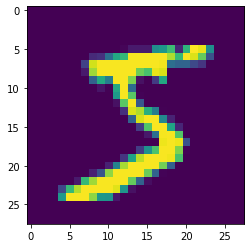

In [16]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [ ]:
len(dataset)

60000

In [ ]:
# разбиваем датасет на тренировочный и тестовый
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(42))

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom веса nn.init.xavier_normal_(self.linear_weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [ ]:
# Формирование батча

def collate_fn(data: list):
  # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(np.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H нормируем чтобы были числа от 0 до 1
    #target = torch.from_numpy(np.array(target)).type(torch.LongTensor)
    target = torch.as_tensor(np.array(target), dtype=torch.long)

    return {
        'data': pics.view(pics.size(0), -1),
        'target': target, # классы
        }


In [ ]:
# hyperparams Управление девайсом
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # видеокарта cuda - 1 процессор, 0 гпу
n_epochs = 10
batch_size = 128

In [ ]:
# инициализация модели
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train()
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [ ]:
%%time
for epoch in range(n_epochs):
    # каждый раз случайное разбиение, поэтому каждый раз новый загрузчик
    dataloader = DataLoader(train_dataset,
                            batch_size,
                            shuffle=True,
                            collate_fn=collate_fn,
                            drop_last = True
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.306894540786743
epoch: 0, step: 200, loss: 0.29865315556526184
epoch: 1, step: 0, loss: 0.2522173821926117
epoch: 1, step: 200, loss: 0.10328377038240433
epoch: 2, step: 0, loss: 0.17839650809764862
epoch: 2, step: 200, loss: 0.10507255792617798
epoch: 3, step: 0, loss: 0.11596290022134781
epoch: 3, step: 200, loss: 0.04517514258623123
epoch: 4, step: 0, loss: 0.09865587204694748
epoch: 4, step: 200, loss: 0.06307872384786606
epoch: 5, step: 0, loss: 0.06813845783472061
epoch: 5, step: 200, loss: 0.0577332079410553
epoch: 6, step: 0, loss: 0.11204257607460022
epoch: 6, step: 200, loss: 0.07631662487983704
epoch: 7, step: 0, loss: 0.03637488931417465
epoch: 7, step: 200, loss: 0.02607671171426773
epoch: 8, step: 0, loss: 0.041029516607522964
epoch: 8, step: 200, loss: 0.01631963811814785
epoch: 9, step: 0, loss: 0.02501017227768898
epoch: 9, step: 200, loss: 0.0392017588019371
CPU times: user 23 s, sys: 531 ms, total: 23.5 s
Wall time: 23.4 s


In [ ]:
test_dataset = collate_fn(test_dataset)

In [ ]:
#проверяем на тестовой выборке
model.train(False)
test_loss = []
correct = 0
incorrect = 0

for i, pics in enumerate(test_dataset.get('data')):
    predict = model(pics.to(device))
    test_loss += [loss_func(predict, test_dataset.get('target')[i].to(device)).item()]
    predict_number = predict.data.max(0)[1]
    if predict_number.eq(test_dataset.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9740
Некорректных ответов: 260
Среднее по всем значениям функции потерь: 0.09322324070811633


In [ ]:
class new_LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        #nn.init.xavier_normal_(self.linear1.weight)
        #nn.init.kaiming_uniform_(self.linear1.weight)
        self.activation = nn.ReLU()
        self.do1 = nn.Dropout(dropout_p)
        self.norm = nn.LayerNorm(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        #self.activation = nn.LogSigmoid()
        
        
        #self.activation = nn.Hardswish()
        #self.activation = nn.Tanhshrink()
        #self.activation = nn.Softshrink()

    def forward(self, x):
        x = self.linear1(x)
        #x = self.norm(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.norm(x)
        x = self.linear2(x)

        return x

In [ ]:
model2 = new_LinearModel(inp_dim, hidden, out_dim).to(device)
model2.train()
#optim = torch.optim.Adam(model2.parameters())
optim = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#optim = torch.optim.Adagrad(model2.parameters())
#optim = torch.optim.RMSprop(model2.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
%%time
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                            batch_size,
                            shuffle=True,
                            collate_fn=collate_fn,
                            drop_last = True
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model2(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model2.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.6460976600646973
epoch: 0, step: 200, loss: 0.2086094468832016
epoch: 1, step: 0, loss: 0.14691577851772308
epoch: 1, step: 200, loss: 0.10619126260280609
epoch: 2, step: 0, loss: 0.039968132972717285
epoch: 2, step: 200, loss: 0.06169428303837776
epoch: 3, step: 0, loss: 0.08776365965604782
epoch: 3, step: 200, loss: 0.031325679272413254
epoch: 4, step: 0, loss: 0.0400242805480957
epoch: 4, step: 200, loss: 0.05220981687307358
epoch: 5, step: 0, loss: 0.043440770357847214
epoch: 5, step: 200, loss: 0.024050798267126083
epoch: 6, step: 0, loss: 0.01117737777531147
epoch: 6, step: 200, loss: 0.07905589789152145
epoch: 7, step: 0, loss: 0.030531244352459908
epoch: 7, step: 200, loss: 0.011733327992260456
epoch: 8, step: 0, loss: 0.015790417790412903
epoch: 8, step: 200, loss: 0.023358015343546867
epoch: 9, step: 0, loss: 0.02916426584124565
epoch: 9, step: 200, loss: 0.0145349046215415
CPU times: user 21.4 s, sys: 577 ms, total: 22 s
Wall time: 21.8 s


In [ ]:
#проверяем на тестовой выборке
model2.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset.get('data')):
    predict = model2(pics.to(device))
    test_loss += [loss_func(predict, test_dataset.get('target')[i].to(device)).item()]
    predict_number = predict.data.max(0)[1]
    if predict_number.eq(test_dataset.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9763
Некорректных ответов: 237
Среднее по всем значениям функции потерь: 0.07878208914492325


Попробовал несколько комбинаций, даже добавлял несколько слоев, но по метрике модель работала хуже. Чуть-чуть получилось улучшить метрики при добавлении нормализации перед внешним линейным слоем и использования оптимизатора SGD c momentum=0.9.

Еще почему-то функция потерь не работала в PyCharm до тех пор, пока я явно не преобразовал целевые показатели в long тензор, хотя на колабе работало все без этого преобразования

# Сверточная сеть

In [40]:
class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        # уменьшит размер картинки в 2 раза
        self.conv = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5*14*14, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.conv3(x)
        x = self.classifier(x.view(x.size(0), -1))

        return x

In [17]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [22]:
def collate_fn_conv(data: list):
    # data = [(pic, target)...]
    pics = list()
    target = list()
    for item in data:
        pics.append(np.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H
    target = torch.from_numpy(np.array(target))

    return {
            'data': pics.unsqueeze(1), # B x 1 x W x H Добавляем измерение 1 это кол-во каналов
            'target': target.long(),
           }

In [44]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
model_conv.train()
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [45]:
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.2852942943573
epoch: 0, step: 200, loss: 0.2259170264005661
epoch: 1, step: 0, loss: 0.05172661319375038
epoch: 1, step: 200, loss: 0.03468224033713341
epoch: 2, step: 0, loss: 0.04158275946974754
epoch: 2, step: 200, loss: 0.017551623284816742
epoch: 3, step: 0, loss: 0.05009631812572479
epoch: 3, step: 200, loss: 0.0655798688530922
epoch: 4, step: 0, loss: 0.006988154724240303
epoch: 4, step: 200, loss: 0.02043874002993107
epoch: 5, step: 0, loss: 0.026885751634836197
epoch: 5, step: 200, loss: 0.034843891859054565
epoch: 6, step: 0, loss: 0.02834133990108967
epoch: 6, step: 200, loss: 0.03538591414690018
epoch: 7, step: 0, loss: 0.056265462189912796
epoch: 7, step: 200, loss: 0.15029819309711456
epoch: 8, step: 0, loss: 0.013453865423798561
epoch: 8, step: 200, loss: 0.03868425264954567
epoch: 9, step: 0, loss: 0.013909545727074146
epoch: 9, step: 200, loss: 0.004515347070991993


In [18]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(42))

In [25]:
test_dataset_conv = collate_fn_conv(test_dataset)

In [48]:
model_conv.train(False)

ConvModel(
  (conv): Conv2d(1, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (classifier): Linear(in_features=980, out_features=10, bias=True)
  (do1): Dropout(p=0.1, inplace=False)
  (do2): Dropout(p=0.1, inplace=False)
  (activation): ReLU()
)

In [49]:
#проверяем на тестовой выборке
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset_conv.get('data')):
    predict = model_conv(pics.unsqueeze(0).to(device))
    test_loss += [loss_func(predict, test_dataset_conv.get('target')[i].unsqueeze(0).to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(test_dataset_conv.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9880
Некорректных ответов: 120
Среднее по всем значениям функции потерь: 0.04646988906469827


# MaxPooling с 2-м сжатием

In [19]:
class ConvModel_with_pooling(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.max_pooling = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        # уменьшит размер картинки в 2 раза
        self.conv = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5*14*14, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.max_pooling(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.conv3(x)
        x = self.classifier(x.view(x.size(0), -1))

        return x

In [20]:
model_conv_with_pooling = ConvModel_with_pooling(input_ch, hidden_ch, out_dim).to(device)
model_conv_with_pooling.train()
optim = torch.optim.Adam(model_conv_with_pooling.parameters())
loss_func = nn.CrossEntropyLoss()

In [23]:
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv_with_pooling(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv_with_pooling.state_dict(), f'./chkpt_cv1_conv_with_pooling_{epoch}.pth')


epoch: 0, step: 0, loss: 2.322575569152832
epoch: 0, step: 200, loss: 0.09948688745498657
epoch: 1, step: 0, loss: 0.14340375363826752
epoch: 1, step: 200, loss: 0.1710178256034851
epoch: 2, step: 0, loss: 0.056104086339473724
epoch: 2, step: 200, loss: 0.08570950478315353
epoch: 3, step: 0, loss: 0.12078048288822174
epoch: 3, step: 200, loss: 0.06066570430994034
epoch: 4, step: 0, loss: 0.03413877636194229
epoch: 4, step: 200, loss: 0.13263563811779022
epoch: 5, step: 0, loss: 0.03915030136704445
epoch: 5, step: 200, loss: 0.07419252395629883
epoch: 6, step: 0, loss: 0.02249988168478012
epoch: 6, step: 200, loss: 0.05348501354455948
epoch: 7, step: 0, loss: 0.05019669979810715
epoch: 7, step: 200, loss: 0.055725570768117905
epoch: 8, step: 0, loss: 0.06613645702600479
epoch: 8, step: 200, loss: 0.05437961220741272
epoch: 9, step: 0, loss: 0.04509729892015457
epoch: 9, step: 200, loss: 0.06513094902038574


In [26]:
#проверяем на тестовой выборке
model_conv_with_pooling.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset_conv.get('data')):
    predict = model_conv_with_pooling(pics.unsqueeze(0).to(device))
    test_loss += [loss_func(predict, test_dataset_conv.get('target')[i].unsqueeze(0).to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(test_dataset_conv.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9801
Некорректных ответов: 199
Среднее по всем значениям функции потерь: 0.07278487113278638


# MaxPooling с 2-м сжатием + сжатие на Conv2d

In [27]:
class ConvModel_with_pooling(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.max_pooling = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        # уменьшит размер картинки в 2 раза
        self.conv = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5*7*7, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.max_pooling(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.conv3(x)
        x = self.classifier(x.view(x.size(0), -1))

        return x

In [28]:
model_conv_with_pooling = ConvModel_with_pooling(input_ch, hidden_ch, out_dim).to(device)
model_conv_with_pooling.train()
optim = torch.optim.Adam(model_conv_with_pooling.parameters())
loss_func = nn.CrossEntropyLoss()

In [29]:
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv_with_pooling(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv_with_pooling.state_dict(), f'./chkpt_cv1_conv_with_pooling_{epoch}.pth')


epoch: 0, step: 0, loss: 2.2997498512268066
epoch: 0, step: 200, loss: 0.10275885462760925
epoch: 1, step: 0, loss: 0.12254931032657623
epoch: 1, step: 200, loss: 0.205256387591362
epoch: 2, step: 0, loss: 0.11813325434923172
epoch: 2, step: 200, loss: 0.13465633988380432
epoch: 3, step: 0, loss: 0.05376173183321953
epoch: 3, step: 200, loss: 0.06561165302991867
epoch: 4, step: 0, loss: 0.056025851517915726
epoch: 4, step: 200, loss: 0.06520818918943405
epoch: 5, step: 0, loss: 0.056372351944446564
epoch: 5, step: 200, loss: 0.028101420029997826
epoch: 6, step: 0, loss: 0.03088829480111599
epoch: 6, step: 200, loss: 0.03371976688504219
epoch: 7, step: 0, loss: 0.03975052759051323
epoch: 7, step: 200, loss: 0.037651464343070984
epoch: 8, step: 0, loss: 0.07360325008630753
epoch: 8, step: 200, loss: 0.11182143539190292
epoch: 9, step: 0, loss: 0.057277608662843704
epoch: 9, step: 200, loss: 0.018220309168100357


In [30]:
#проверяем на тестовой выборке
model_conv_with_pooling.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset_conv.get('data')):
    predict = model_conv_with_pooling(pics.unsqueeze(0).to(device))
    test_loss += [loss_func(predict, test_dataset_conv.get('target')[i].unsqueeze(0).to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(test_dataset_conv.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9779
Некорректных ответов: 221
Среднее по всем значениям функции потерь: 0.07285896637573333


# MaxPooling без сжатия + сжатие на Conv2d

In [35]:
class ConvModel_with_pooling(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.max_pooling = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        # уменьшит размер картинки в 2 раза
        self.conv = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5*14*14, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.max_pooling(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.conv3(x)
        x = self.classifier(x.view(x.size(0), -1))

        return x

In [36]:
model_conv_with_pooling = ConvModel_with_pooling(input_ch, hidden_ch, out_dim).to(device)
model_conv_with_pooling.train()
optim = torch.optim.Adam(model_conv_with_pooling.parameters())
loss_func = nn.CrossEntropyLoss()

In [37]:
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv_with_pooling(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv_with_pooling.state_dict(), f'./chkpt_cv1_conv_with_pooling_{epoch}.pth')

epoch: 0, step: 0, loss: 2.310537338256836
epoch: 0, step: 200, loss: 0.15938109159469604
epoch: 1, step: 0, loss: 0.1515197455883026
epoch: 1, step: 200, loss: 0.1293402761220932
epoch: 2, step: 0, loss: 0.0929345041513443
epoch: 2, step: 200, loss: 0.034682098776102066
epoch: 3, step: 0, loss: 0.02970503643155098
epoch: 3, step: 200, loss: 0.09949753433465958
epoch: 4, step: 0, loss: 0.0680297315120697
epoch: 4, step: 200, loss: 0.15676115453243256
epoch: 5, step: 0, loss: 0.09326082468032837
epoch: 5, step: 200, loss: 0.06744071841239929
epoch: 6, step: 0, loss: 0.014009212143719196
epoch: 6, step: 200, loss: 0.026402056217193604
epoch: 7, step: 0, loss: 0.002690432360395789
epoch: 7, step: 200, loss: 0.035357117652893066
epoch: 8, step: 0, loss: 0.038384515792131424
epoch: 8, step: 200, loss: 0.007077234797179699
epoch: 9, step: 0, loss: 0.029265249148011208
epoch: 9, step: 200, loss: 0.058835018426179886


In [39]:
#проверяем на тестовой выборке
model_conv_with_pooling.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset_conv.get('data')):
    predict = model_conv_with_pooling(pics.unsqueeze(0).to(device))
    test_loss += [loss_func(predict, test_dataset_conv.get('target')[i].unsqueeze(0).to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(test_dataset_conv.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9820
Некорректных ответов: 180
Среднее по всем значениям функции потерь: 0.06817188110915332


# MaxPooling с уменьшением картинки в середине

In [31]:
class ConvModel_with_pooling(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.max_pooling = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        # уменьшит размер картинки в 2 раза
        self.conv = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1)
        self.bn1 = nn.BatchNorm2d(hidden_ch)
        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(hidden_ch)
        self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
        self.classifier = nn.Linear(5*14*14, output_dim)
        self.do1 = nn.Dropout(dropout_p)
        self.do2 = nn.Dropout(dropout_p)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.max_pooling(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.conv3(x)
        x = self.classifier(x.view(x.size(0), -1))

        return x

In [32]:
model_conv_with_pooling = ConvModel_with_pooling(input_ch, hidden_ch, out_dim).to(device)
model_conv_with_pooling.train()
optim = torch.optim.Adam(model_conv_with_pooling.parameters())
loss_func = nn.CrossEntropyLoss()

In [33]:
for epoch in range(n_epochs):
    dataloader = DataLoader(train_dataset,
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv_with_pooling(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv_with_pooling.state_dict(), f'./chkpt_cv1_conv_with_pooling_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3614718914031982
epoch: 0, step: 200, loss: 0.15462180972099304
epoch: 1, step: 0, loss: 0.11088263243436813
epoch: 1, step: 200, loss: 0.03862470015883446
epoch: 2, step: 0, loss: 0.0060148537158966064
epoch: 2, step: 200, loss: 0.03107054904103279
epoch: 3, step: 0, loss: 0.010172602720558643
epoch: 3, step: 200, loss: 0.016677362844347954
epoch: 4, step: 0, loss: 0.08664847165346146
epoch: 4, step: 200, loss: 0.05830168351531029
epoch: 5, step: 0, loss: 0.009086942300200462
epoch: 5, step: 200, loss: 0.046205274760723114
epoch: 6, step: 0, loss: 0.013298513367772102
epoch: 6, step: 200, loss: 0.00030108762439340353
epoch: 7, step: 0, loss: 0.04806527495384216
epoch: 7, step: 200, loss: 0.02047557383775711
epoch: 8, step: 0, loss: 0.016186121851205826
epoch: 8, step: 200, loss: 0.022527379915118217
epoch: 9, step: 0, loss: 0.018666639924049377
epoch: 9, step: 200, loss: 0.011855421587824821


In [34]:
#проверяем на тестовой выборке
model_conv_with_pooling.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(test_dataset_conv.get('data')):
    predict = model_conv_with_pooling(pics.unsqueeze(0).to(device))
    test_loss += [loss_func(predict, test_dataset_conv.get('target')[i].unsqueeze(0).to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(test_dataset_conv.get('target')[i]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 9878
Некорректных ответов: 122
Среднее по всем значениям функции потерь: 0.048880310819382086


**Вывод:** *При использовании процессора, применение MaxPooling не дает ощутимого прироста, но если использовать GPU (например, в колабе), то применение MaxPooling с уменьшением картинки в середине сети дает наилучшую метрику.
Результаты не сохранились, так как закончился доступ к GPU, но на практике проверено*

# Дообучение модели

In [4]:
model_alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_alexnet.eval()

Using cache found in C:\Users\diman/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\diman\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\diman\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
datasets_flowers = {
    'train': ImageFolder(
        root='flowers/train/',
        transform=preprocess
    ),
    'test': ImageFolder(
        root='flowers/test/',
        transform=preprocess
    ),
}

datasets_flowers['train'].class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [4]:
# hyperparams Управление девайсом
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # видеокарта cuda - 1 процессор, 0 гпу
n_epochs = 10
batch_size = 128

In [8]:
model_alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
for param in model_alexnet.parameters():
    param.requires_grad = False

In [10]:
model_alexnet.classifier[6] = torch.nn.Linear(4096, 5).to(device)

In [11]:
params_to_update = []
for name,param in model_alexnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
print(f"Params to learn:{params_to_update}")

Params to learn:[Parameter containing:
tensor([[-0.0007, -0.0056, -0.0053,  ..., -0.0053, -0.0078,  0.0036],
        [-0.0152, -0.0070, -0.0051,  ...,  0.0150, -0.0036,  0.0055],
        [ 0.0033,  0.0097, -0.0112,  ..., -0.0031, -0.0014,  0.0064],
        [ 0.0098,  0.0078, -0.0156,  ...,  0.0005,  0.0060, -0.0090],
        [-0.0022, -0.0102,  0.0077,  ...,  0.0086,  0.0142, -0.0010]],
       requires_grad=True), Parameter containing:
tensor([-0.0083,  0.0112, -0.0150, -0.0037, -0.0006], requires_grad=True)]


In [12]:
optim = torch.optim.Adam(params_to_update)
loss_func = nn.CrossEntropyLoss()

In [14]:
for epoch in range(n_epochs):
    dataloader = DataLoader(datasets_flowers['train'],
                            batch_size,
                            shuffle=True,
                            drop_last = True
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_alexnet(batch[0].to(device))
        loss = loss_func(predict, batch[1].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_alexnet.state_dict(), f'./chkpt_model_alexnet_{epoch}.pth')

epoch: 0, step: 0, loss: 1.6226563453674316
epoch: 1, step: 0, loss: 0.4390919804573059
epoch: 2, step: 0, loss: 0.15636278688907623
epoch: 3, step: 0, loss: 0.14768086373806
epoch: 4, step: 0, loss: 0.10629848390817642
epoch: 5, step: 0, loss: 0.11322282999753952
epoch: 6, step: 0, loss: 0.05256054177880287
epoch: 7, step: 0, loss: 0.05532310530543327
epoch: 8, step: 0, loss: 0.06085313484072685
epoch: 9, step: 0, loss: 0.04409520700573921


In [26]:
model_alexnet.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(datasets_flowers['train']):
    predict = model_alexnet(pics[0].unsqueeze(0).to(device))
    test_loss += [loss_func(predict, torch.from_numpy(np.array(pics[1])).unsqueeze(0).long().to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(pics[1]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 3802
Некорректных ответов: 11
Среднее по всем значениям функции потерь: 0.0402277017851853


# Обучение с 0

In [8]:
model_alexnet_not_tuned = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False).to(device)
model_alexnet_not_tuned.classifier[6] = torch.nn.Linear(4096, 5).to(device)
model_alexnet_not_tuned.train()
optim = torch.optim.Adam(model_alexnet_not_tuned.parameters())
loss_func = nn.CrossEntropyLoss()

Using cache found in C:\Users\diman/.cache\torch\hub\pytorch_vision_v0.10.0


In [9]:
for epoch in range(n_epochs):
    dataloader = DataLoader(datasets_flowers['train'],
                            batch_size,
                            shuffle=True,
                            drop_last = True
                            )
    for i, batch in tqdm(enumerate(dataloader)):
        optim.zero_grad()

        predict = model_alexnet_not_tuned(batch[0].to(device))
        loss = loss_func(predict, batch[1].to(device))
        loss.backward()
        optim.step()
        if i % 10 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_alexnet_not_tuned.state_dict(), f'./chkpt_model_alexnet_not_tuned_{epoch}.pth')

0it [00:00, ?it/s]

epoch: 0, step: 0, loss: 1.6103599071502686
epoch: 0, step: 10, loss: 1.610506296157837
epoch: 0, step: 20, loss: 1.595742106437683


0it [00:00, ?it/s]

epoch: 1, step: 0, loss: 1.6126811504364014
epoch: 1, step: 10, loss: 1.470076084136963
epoch: 1, step: 20, loss: 1.4400838613510132


0it [00:00, ?it/s]

epoch: 2, step: 0, loss: 1.3823060989379883
epoch: 2, step: 10, loss: 1.3015702962875366
epoch: 2, step: 20, loss: 1.338711142539978


0it [00:00, ?it/s]

epoch: 3, step: 0, loss: 1.248781442642212
epoch: 3, step: 10, loss: 1.2734605073928833
epoch: 3, step: 20, loss: 1.2738271951675415


0it [00:00, ?it/s]

epoch: 4, step: 0, loss: 1.2312602996826172
epoch: 4, step: 10, loss: 1.232183814048767
epoch: 4, step: 20, loss: 0.9402750134468079


0it [00:00, ?it/s]

epoch: 5, step: 0, loss: 1.2504042387008667
epoch: 5, step: 10, loss: 1.237357497215271
epoch: 5, step: 20, loss: 1.230269432067871


0it [00:00, ?it/s]

epoch: 6, step: 0, loss: 1.155895709991455
epoch: 6, step: 10, loss: 1.0380641222000122
epoch: 6, step: 20, loss: 1.0225683450698853


0it [00:00, ?it/s]

epoch: 7, step: 0, loss: 1.2125284671783447
epoch: 7, step: 10, loss: 0.9684135317802429
epoch: 7, step: 20, loss: 1.0287060737609863


0it [00:00, ?it/s]

epoch: 8, step: 0, loss: 0.8299262523651123
epoch: 8, step: 10, loss: 0.9678186178207397
epoch: 8, step: 20, loss: 0.9396075010299683


0it [00:00, ?it/s]

epoch: 9, step: 0, loss: 1.0415371656417847
epoch: 9, step: 10, loss: 0.7706637978553772
epoch: 9, step: 20, loss: 1.0555088520050049


In [10]:
model_alexnet_not_tuned.train(False)
test_loss = []
correct = 0
incorrect = 0
for i, pics in enumerate(datasets_flowers['train']):
    predict = model_alexnet_not_tuned(pics[0].unsqueeze(0).to(device))
    test_loss += [loss_func(predict, torch.from_numpy(np.array(pics[1])).unsqueeze(0).long().to(device)).item()]
    predict_number = predict.data[0].max(0)[1]
    if predict_number.eq(pics[1]).item() is True:
        correct += 1
    else:
        incorrect += 1

print(f'Корректных ответов: {correct}',
      f'Некорректных ответов: {incorrect}',
      f'Среднее по всем значениям функции потерь: {np.mean(test_loss)}', sep='\n')

Корректных ответов: 2457
Некорректных ответов: 1356
Среднее по всем значениям функции потерь: 0.9053095094567722


**Вывод:** *Использование предобученной модели дает колоссальную разницу в результатах. На одном и том же датасете с одним и тем же набором картинок результат отличается на порядок. Кроме того, дообучить модель значительно быстрее обучения ее с 0*